### Import libraries

In [275]:
import pandas as pd
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np
from catboost import Pool
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Exploratory Analysis

In [276]:
df = pd.read_csv('train.csv', index_col=0)

#### Cleaning the data

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Get the amount of null values in percentage

In [278]:
df.isnull().sum() / len(df) * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Look at the distributions of the features to decide with wich method we will fill the null values

<AxesSubplot: >

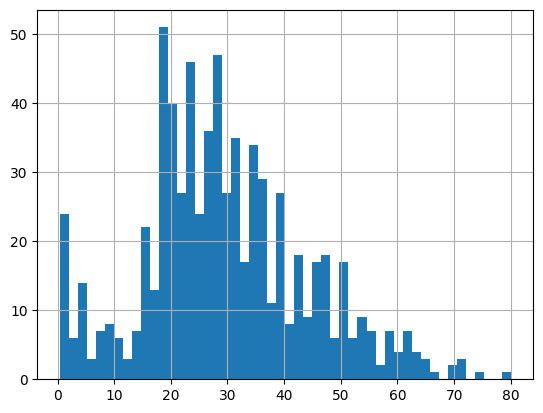

In [279]:
df["Age"].hist(bins=50)

We will use the median to fill the null values in Age

<AxesSubplot: >

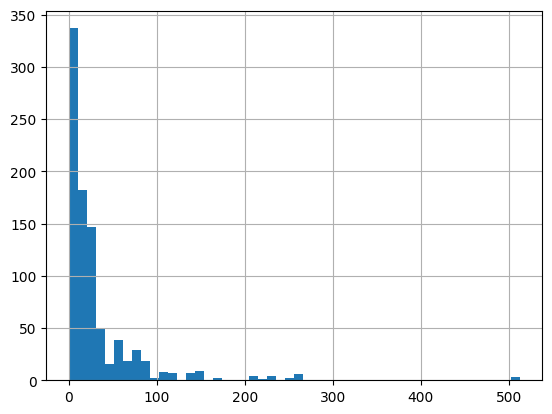

In [280]:
df["Fare"].hist(bins=50)

We will use the median to fill the null values in Fare

<AxesSubplot: >

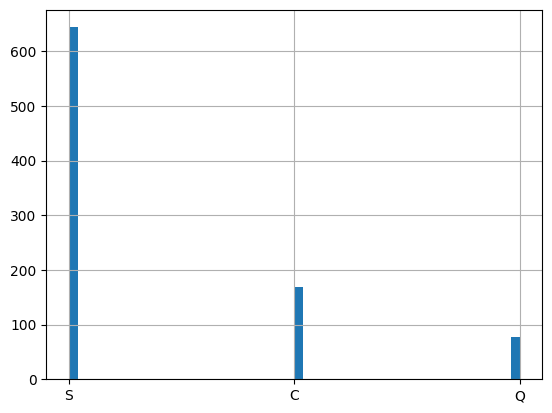

In [281]:
df["Embarked"].hist(bins=50)

We will use mode to fill the null values in Embarked

#### Feature engineering

We are going to do the analysis based on the idea that women and children were given priority to board the lifeboats.

We will deduce the passengers gender based on the title in their names. 

In [282]:
# Extract titles from the 'Name' column
df['Title'] = df['Name'].apply(lambda x: x.split(",")[1].split(".")[0].strip())
df.value_counts("Title")

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
dtype: int64

Replace titles with general categories

In [283]:
df['Title'] = df['Title'].replace({
    "Capt": "man", "Don": "man", "Major": "man", "Col": "man", 
    "Rev": "man", "Dr": "man", "Sir": "man", "Mr": "man", "Jonkheer": "man",
    "Dona": "woman", "the Countess": "woman", "Mme": "woman", 
    "Mlle": "woman", "Ms": "woman", "Miss": "woman", "Lady": "woman", "Mrs": "woman",
    "Master": "boy"
})
df.value_counts("Title")

Title
man      538
woman    313
boy       40
dtype: int64

We will group people by families

In [284]:
# Extract surnames from the 'Name' column
df['Surname'] = df['Name'].apply(lambda x: x.split(",")[0])

# Group 'man' titles under 'noGroup'
df.loc[df['Title'] == 'man', 'Surname'] = 'noGroup'

# Calculate the frequency of surnames
df['SurnameFreq'] = df.groupby('Surname')['Surname'].transform('count')

# Group surnames that appear only once under 'noGroup'
df.loc[df['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'

In [285]:
df['SurnameSurvival'] = df.groupby('Surname')['Survived'].transform('mean')

The SurnameSurvival feature is calculated by grouping the data by Surname and taking the mean of the Survived column for each group. This gives the overall survival rate for each surname.

In [286]:
df['AdjustedSurvival'] = (df['SurnameSurvival'] * df['SurnameFreq'] - df['Survived']) / (df['SurnameFreq'] - 1)

AdjustedSurvival adjusts the SurnameSurvival rate to provide a better estimate of the survival rate for each passenger, taking into account the number of people with the same surname (SurnameFreq) and the actual survival of the individual passenger (Survived).

This feature is intended to provide a more reliable estimate of the survival probability for each passenger based on their surname.

#### Data Preprocessing Function

In [287]:
def preprocess_data(data):

    # Extract titles from the 'Name' column
    data['Title'] = data['Name'].apply(lambda x: x.split(",")[1].split(".")[0].strip())

    # Replace titles with general categories
    data['Title'] = data['Title'].replace({
        "Capt": "man", "Don": "man", "Major": "man", "Col": "man", 
        "Rev": "man", "Dr": "man", "Sir": "man", "Mr": "man", "Jonkheer": "man",
        "Dona": "woman", "the Countess": "woman", "Mme": "woman", 
        "Mlle": "woman", "Ms": "woman", "Miss": "woman", "Lady": "woman", "Mrs": "woman",
        "Master": "boy"
    })

    # Extract surnames from the 'Name' column
    data['Surname'] = data['Name'].apply(lambda x: x.split(",")[0])

    # Group 'man' titles under 'noGroup'
    data.loc[data['Title'] == 'man', 'Surname'] = 'noGroup'

    # Calculate the frequency of surnames
    data['SurnameFreq'] = data.groupby('Surname')['Surname'].transform('count')

    # Group surnames that appear only once under 'noGroup'
    data.loc[data['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'

    # Calculate the survival rates for 'woman-child-groups'
    data['SurnameSurvival'] = data.groupby('Surname')['Survived'].transform('mean')

    # Adjust survival rates for use on the training set
    data['AdjustedSurvival'] = (data['SurnameSurvival'] * data['SurnameFreq'] - data['Survived']) / (data['SurnameFreq'] - 1)

    # if the adjust survival rate is -inf or inf
    data['AdjustedSurvival'] = data['AdjustedSurvival'].replace(np.inf, 1) # this means that all the people with the same surname survived
    data['AdjustedSurvival'] = data['AdjustedSurvival'].replace(-np.inf, 0) # this means that all the people with the same surname died

    data.drop(['Name', 'Ticket', 'Cabin', 'Surname', 'SurnameFreq', 'Title'], axis=1, inplace=True)

    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data = pd.get_dummies(data, columns=['Embarked'])
    
    return data

### Prepare the Data

In [288]:
train = pd.read_csv("train.csv", index_col=0)
train = preprocess_data(train)

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

len(X_train), len(y_train)

(891, 891)

In [289]:
test = pd.read_csv('test_with_survived.csv', index_col=0)
test = preprocess_data(test)

y_test = test['Survived']
X_test = test.drop(["Survived"], axis=1)

len(X_test), len(y_test)

(418, 418)

### Model

We will use catboost, therefore we need to indicate the categorical features.

In [290]:
cat_features = np.where(X_train.dtypes != float)[0]
cat_features

array([ 0,  1,  3,  4,  8,  9, 10], dtype=int64)

Create the Model

In [291]:
# fit the model
model = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose=False, use_best_model=True, random_seed=42, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# make predictions
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
accuracy # 0.8947368421052632

0.8947368421052632

In [292]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       260
           1       1.00      0.72      0.84       158

    accuracy                           0.89       418
   macro avg       0.93      0.86      0.88       418
weighted avg       0.91      0.89      0.89       418



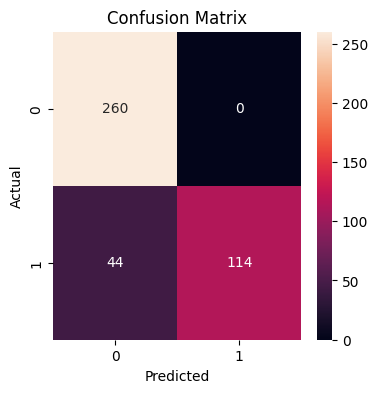

In [293]:
plt.figure(figsize = (4,4))
cm = sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True)
cm.set(title='Confusion Matrix')
cm.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [294]:
# get the feature importance
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,AdjustedSurvival,65.674739
1,SurnameSurvival,33.395220
2,Sex,0.930041
3,Pclass,0.000000
4,Age,0.000000
5,SibSp,0.000000
6,Parch,0.000000
7,Fare,0.000000
8,Embarked_C,0.000000
9,Embarked_Q,0.000000


Hyperparameter Tuning

We are going to find the best parameters for the model using GridSearchCV. Also, we are going to use Cross Validation to avoid overfitting.

In [295]:
'''
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='Accuracy',
                                    verbose=False,
                                    random_state=42)

params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
}

grid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)

best_model = CatBoostClassifier(depth=grid['params']['depth'],
                                loss_function='Logloss',
                                eval_metric='Accuracy',
                                use_best_model=True,
                                random_seed=42,
                                verbose=False)

best_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))

accuracy_score(y_test, best_model.predict(X_test))
'''

"\ncat_for_search = CatBoostClassifier(loss_function='Logloss',\n                                    eval_metric='Accuracy',\n                                    verbose=False,\n                                    random_state=42)\n\nparams = {\n    'depth': [4, 6, 8, 10],\n    'learning_rate': [0.01, 0.05, 0.1, 0.2],\n    'iterations': [100, 200, 300, 500],\n    'l2_leaf_reg': [1, 3, 5, 7],\n}\n\ngrid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)\n\nbest_model = CatBoostClassifier(depth=grid['params']['depth'],\n                                loss_function='Logloss',\n                                eval_metric='Accuracy',\n                                use_best_model=True,\n                                random_seed=42,\n                                verbose=False)\n\nbest_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))\n\naccuracy_score(y_test, best_mod